In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve

In [2]:
# simple auc functions taken from sklearn

def trapezoid(y, x=None, dx=1.0, axis=-1):
    y = np.asanyarray(y)
    if x is None:
        d = dx
    else:
        x = np.asanyarray(x)
        if x.ndim == 1:
            d = np.diff(x)
            # reshape to correct shape
            shape = [1]*y.ndim
            shape[axis] = d.shape[0]
            d = d.reshape(shape)
        else:
            d = np.diff(x, axis=axis)
    nd = y.ndim
    slice1 = [slice(None)]*nd
    slice2 = [slice(None)]*nd
    slice1[axis] = slice(1, None)
    slice2[axis] = slice(None, -1)
    try:
        ret = (d * (y[tuple(slice1)] + y[tuple(slice2)]) / 2.0).sum(axis)
    except ValueError:
        # Operations didn't work, cast to ndarray
        d = np.asarray(d)
        y = np.asarray(y)
        ret = np.add.reduce(d * (y[tuple(slice1)]+y[tuple(slice2)])/2.0, axis)
    return ret

def auc(x, y):
    if x.shape[0] < 2:
        raise ValueError(
            "At least 2 points are needed to compute area under curve, but x.shape = %s"
            % x.shape
        )

    direction = 1
    dx = np.diff(x)
    if np.any(dx < 0):
        if np.all(dx <= 0):
            direction = -1
        else:
            raise ValueError("x is neither increasing nor decreasing : {}.".format(x))

    area = direction * trapezoid(y, x)
    if isinstance(area, np.memmap):
        # Reductions such as .sum used internally in trapezoid do not return a
        # scalar by default for numpy.memmap instances contrary to
        # regular numpy.ndarray instances.
        area = area.dtype.type(area)
    return area



In [3]:
full_data = pd.read_csv('data/comment_data_general_091022_untilarticle5874_final_redacted.csv', index_col=0)
xgbpreds = pd.read_csv('model_output/xgbs/pred_pinned_xgb.csv', index_col=0)
lrpreds = pd.read_csv('model_output/regressions/pred_pinned_lr.csv', index_col=0)

predsdf = pd.concat([xgbpreds, lrpreds, full_data['pinned_f']], axis=1)
df_train, df_test = train_test_split(predsdf, test_size=0.2,
                                                    random_state=42)

df_test


,article,comment_id,pred_pinned,pred,pinned_f
343456,/story/2000139105880/machtwechsel-in-schweden-...,content2EqVUMZbPjBMSRApzRIq42ImCHo,1.744311e-09,1.963923e-09,0
573789,/story/2000139360644/tragoedie-und-farce,content2FFrwwgi3mXyGkx1YdQgb7YxuhD,1.699635e-07,4.978306e-06,0
808502,/story/2000139654269/regierung-praesentiert-vi...,content2Ff8RZFZdUf9F3M9yt78OiN1nBy,7.209889e-06,1.752996e-04,0
1055482,/story/2000139927125/ringe-der-macht-macht-vor...,content2GBRuRx6qC5rcQl2b9mHN1BeDV5,8.093006e-10,1.963923e-09,0
625335,/story/2000139375684/sudoku-extrem-schwierig-5...,content2FJTSE2kk8yEIWLSxDvIAauqrLg,5.796113e-06,3.023364e-03,0
...,...,...,...,...,...
1185743,/story/2000140157026/wiener-energiebonusgruene...,content2GPeA0FBv6izSRT4IObc4MP6e34,1.551162e-06,1.963923e-09,0
744062,/story/2000139586997/wohin-mit-dem-protest,content2FXpGbxqzNsRIipIggREEbvNNgO,1.938377e-09,1.963923e-09,0
249774,/story/2000139003445/europas-energiekonzerne-s...,content2Ed5R4e18l6BJfkZGbcFJquboMa,1.066443e-05,4.917184e-05,0
1173557,/story/2000139742304/sudoku-extrem-schwierig-5...,content2GQOK7mCOxlzdKUZfYxroYbKYUE,3.728033e-07,4.236119e-06,0


In [4]:
xgb_pr = precision_recall_curve(df_test['pinned_f'], df_test['pred_pinned'])
lr_pr = precision_recall_curve(df_test['pinned_f'], df_test['pred'])

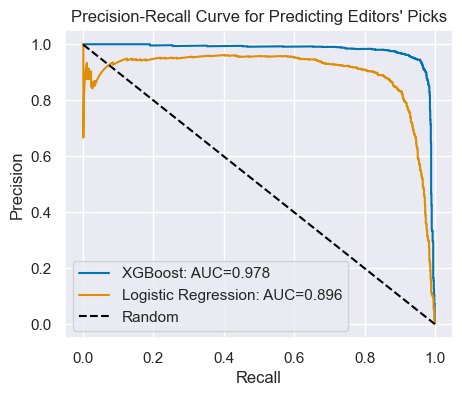

In [5]:
sns.set_theme(style="darkgrid")
sns.set_palette("colorblind")

auc_xgb = auc(xgb_pr[1], xgb_pr[0])
auc_lr = auc(lr_pr[1], lr_pr[0])

plt.figure(figsize=(5, 4))
plt.plot(xgb_pr[1], xgb_pr[0], label='XGBoost: AUC='+str(round(auc_xgb, 3)))
plt.plot(lr_pr[1], lr_pr[0], label='Logistic Regression: AUC='+str(round(auc_lr, 3)))
plt.plot([1, 0], [0, 1], linestyle='--', color='black', label='Random')
# plt.plot(rf['Recall'], rf['f1'], label='Random Forest F1', linestyle='--')
# plt.plot(lr['recall'], lr['f1'], label='Logistic Regression F1', linestyle='--')
plt.title('Precision-Recall Curve for Predicting Editors\' Picks')
plt.xlabel('Recall')
plt.ylabel('Precision')

plt.legend(loc='lower left')
plt.savefig('figs/precision_recall_curve.pdf', bbox_inches='tight')
plt.savefig('figs/precision_recall_curve.svg', bbox_inches='tight')
plt.show()